# Приоритизация гипотез и анализ A/B-теста

**Описание исследования**

Заказчик - крупный интернет-магазин. Необходимо приоритизировать гипотезы из списка, запустить A/B-тест и проанализировать результаты. Цель - увеличить выручку.

**Цель исследования** - проверить выбранную гипотезу на увеличение выручки.

**Описание данных**

1) Данные для первой части - список из подготовленных гипотез:

1. Hypothesis — краткое описание гипотезы;
2. Reach — охват пользователей по 10-балльной шкале;
3. Impact — влияние на пользователей по 10-балльной шкале;
4. Confidence — уверенность в гипотезе по 10-балльной шкале;
5. Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2) Данные для второй части - таблицы, содержащие информацию об покупках и пользователях:

Таблица orders:

1. transactionId — идентификатор заказа
2. visitorId — идентификатор пользователя, совершившего заказ
3. date — дата, когда был совершён заказ
4. revenue — выручка заказа
5. group — группа A/B-теста, в которую попал заказ

Таблица visitors:

1. date — дата
2. group — группа A/B-теста
3. visitors — количество пользователей в указанную дату в указанной группе A/B-теста


**Ход исследования**
 
Перед тем, как непосредственно перейти к проверке гипотезы необходимо провести обзор данных, предобработку и приоритизацию гипотез.
 
Таким образом, исследование пройдёт в четыре этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Приоритезация гипотез.
 4. Анализ результатов теста.

## Обзор данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Откроем датасеты
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# Получим общую информацию о данных
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [6]:
# Проверим на наличие дубликатов
hypothesis.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

In [8]:
visitors.duplicated().sum()

0

**Вывод:**
- В трех таблицах нет пропущенных значений
- В трех таблицах нет дубликатов
- Необходимо изменить типы данных на datetime в visitors['date'], orders['date']
- Необходимо привести названия колонок к одному виду
- Возможно есть пользователи, попавшие в обе группы

## Предобработка данных

In [9]:
# Переведем названия в строчные буквы
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

In [10]:
# Заменим пробелы на нижнее подчеркивание
orders = orders.rename(columns={'transactionid':'transaction_id', 'visitorid':'visitor_id'})

In [11]:
# Изменим тип данных на datetime в visitors['date'], orders['date']
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [12]:
# Найдем пользователей, попавших в обе группы и посчитаем их долю
duplicates = np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())
sum((orders[['visitor_id', 'group']].drop_duplicates().groupby('visitor_id')['group'].count())>1)/len(orders)

0.04845446950710108

In [13]:
# Так как доля мала можно удалить их из датафрейма, чтобы не искажать результаты
orders = orders[~orders['visitor_id'].isin(duplicates)]

In [14]:
# Проверим
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [16]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Вывод:**
- Данные были успешно приведены к одному виду
- В колонках visitors['date'], orders['date'] тип данных был изменен на datetime
- Были найдены и удалены пользователи, попавшие в обе группы

## Приоритизация гипотез

### Фреймворк ICE

In [17]:
# Применим фреймворк ICE к таблице hypothesis и отсортируем гипотезы их по убыванию приоритета
# ICE SCORE = impact * confidence / efforts
pd.options.display.max_colwidth=400
hypothesis['ice'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


### Фреймворк RICE

In [18]:
# Применим фреймворк RICE к таблице hypothesis и отсортируем гипотезы их по убыванию приоритета
# RICE SCORE = impact * confidence * reach / efforts
pd.options.display.max_colwidth=400
hypothesis['rice'] = hypothesis['impact']*hypothesis['confidence']*hypothesis['reach']/hypothesis['efforts']
hypothesis.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


### Промежуточный вывод

- Наиболее перспективные гипотезы по фреймворку ICE - 8, 0, 7
- Наиболее перспективные гипотезы по фреймворку RICE = 7, 2, 0
- Гипотезы 7 и 0 присутствуют в обоих топах. Гипотезы 7 и 2 появляется в топе RICE, так как обладает высоким показателем в параметре reach, то есть затрагивает много пользователей. 8 гипотезы напротив там нет, так как ее показатель reach = 1.

## Анализ результатов теста

### Кумулятивная выручка по группам

In [19]:
# Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates()
dates_groups = orders[['date','group']].drop_duplicates() 

In [20]:
# Соберём агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [21]:
# Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [22]:
# Объединим обе таблицы в одну с понятными названиями столбцов
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

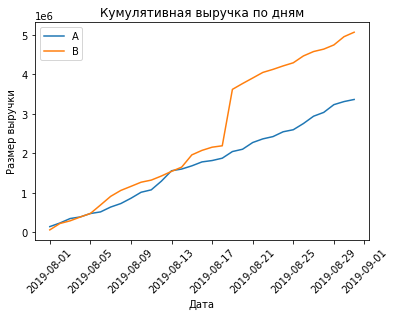

In [23]:
# Построим датафреймы с кумулятивной выручкой по дням в группе А и B
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Построим графики кумулятивной выручки по дням и группам A/B-тестирования
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.legend()
plt.title('Кумулятивная выручка по дням')
plt.xlabel('Дата')
plt.ylabel('Размер выручки')
plt.xticks(rotation=45) 
plt.show()

**Вывод:**

Судя по графику, выручка группы Б стабильно выше выручки группы А. Под конец периода разница между выручками достаточно большая. Однако есть резкий скачок вверх, что может говорить о появлении очень дорогих заказах или об их всплеске.

### Кумулятивный средний чек по группам

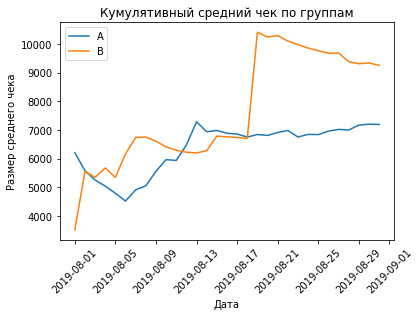

In [24]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Размер среднего чека')
plt.xticks(rotation=45) 
plt.show()

**Вывод:**

Средний чек группы А также выше среднего чека группы Б, под конец периода наблюдается спад у группы Б, и небольшой рост у группы А. Аналогично с графиком кумулятивной выручки у группы Б есть резкий скачок примерно в тот же временной промежуток. Вероятно, в этот период был очень дорогой заказ, который привел к увеличению выручки, которая в свою очередь увеличила средний чек.

### Относительное изменение кумулятивного среднего чека группы B к группе A

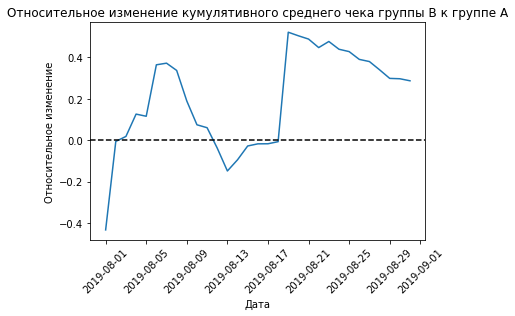

In [25]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=45) 
plt.show()

**Вывод:**

Судя по графику можно сказать, что различия между средними чеками двух групп достаточно сильные. Ест резкие скачки как вверх, так и вниз примерно в тех же местах, что и на предыдущем графике.

### Кумулятивная конверсия по группам

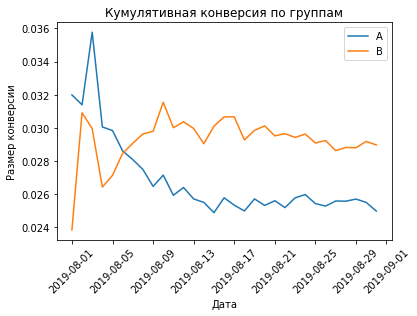

In [26]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Размер конверсии')
plt.xticks(rotation=45) 
plt.show() 

**Вывод:**

В начале периода, у группы А касательно конверсии более высокие результаты, однако постепенно конверсия пользователей из группы Б увеличивается и становится значительно выше. Дальше идет спад, однако конверсии не достаточно стабилизировались под конец.

### Относительное изменение кумулятивной конверсии

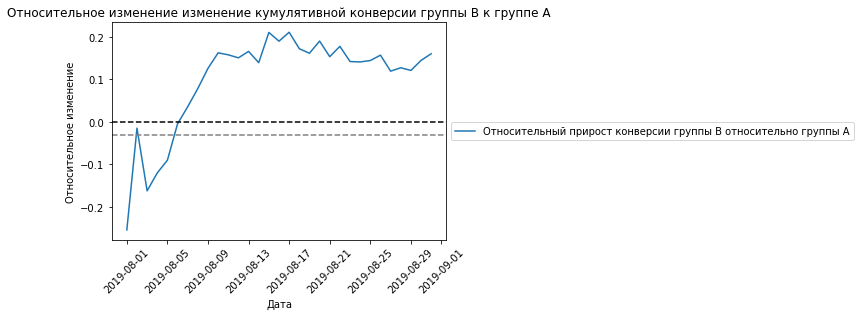

In [27]:
# Построим график относительного различия кумулятивных конверсий
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.032, color='grey', linestyle='--')
plt.title('Относительное изменение изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=45) 
plt.show()

**Вывод:**

На данном графике также видно увеличение конверсии в пользу группы Б, несмотря на то, что в начале периода есть спад. 

### Промежуточные выводы

- И кумулятивная выручка, и средний чек, и конверсия показывают более высокие результаты у группы Б.
- Тем не менее, в отличие от выручки другие показатели дают менее стабильные результаты: под конец периода есть спад, а потом небольшой подъем. Это может говорить о том, что в данных появились очень дорогие заказы, а затем сменились стандартными, однако спад не такой резкий как подьем.
- Также об успешности теста лучше судить, исходя из гипотезы, необходимо знать на что направлен тест, на увеличение выручки благодаря привлечению новых пользователей или благодаря активизации старых.

### Количество заказов по пользователям, 95-й, 99-й перцентили

In [28]:
# Посчитаем кол-во заказов на пользователя
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))
orders_by_users.columns = ['user_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


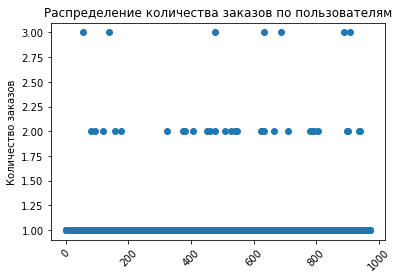

In [29]:
# Построим график
x_value = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_value, orders_by_users['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45) 
plt.show()

In [30]:
# Посчитеам 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(orders_by_users['orders'], [95, 99])

array([1., 2.])

**Вывод:** 
- Судя по таблице и по графику, есть пользователи и с 9, и с 11 заказами, что сильно отличается от остальной картины
- Судя по перцентилям, 95 процентов клиентов ограничиваются одним заказом, и лишь 1 процент заказывают больше двуъ
- Так как, по графику заметно, что пользователи все же часто совершают два заказа, стоит это учитывать и ограничить данные двумя заказами.

### Стоимости заказов, 95-й, 99-й перцентили

In [31]:
# Изучим максимальные значения выручки
orders.sort_values(by='revenue', ascending=False)

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
...,...,...,...,...,...
404,2052514069,1995481842,2019-08-28,70,B
933,3760662696,3577713868,2019-08-27,60,B
584,1126146019,2705308997,2019-08-20,50,A
756,125335873,3423937755,2019-08-30,50,B


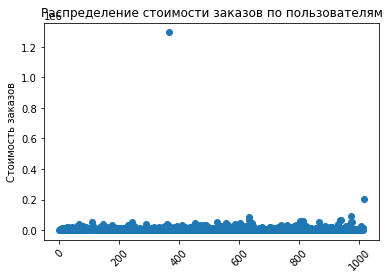

In [32]:
# Построим точечный график
x_value = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_value, orders['revenue'])
plt.title('Распределение стоимости заказов по пользователям')
plt.ylabel('Стоимость заказов')
plt.xticks(rotation=45) 
plt.show()

In [33]:
# Посчитаем 95-й и 99-й перцентили стоимости заказов
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

**Вывод:** 
- Судя по таблице и по графику, есть пользователи, совершившие покупку на двести тысяч и даже миллион, что будет существенно искажать результаты. В основном, выручка колеблется от самых низких значений до 50000.
- Судя по перцентилям, 95 процентов клиентов покупают на сумму 26 тысяч, и лишь 1 процент превышают сумму в 53 тысячи.
- Так как, это данные крупного магазина и по графику заметно, что большинство значений однородно расположились в районе 50р-50000, имеет смысл ограничить данные выручкой в 40000 рублей.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

In [34]:
# Нулевая гипотеза - различий в конверсии между группами нет.
# Альтернативная гипотеза - различия в конверсии между группами есть.
# alpha = 0.05
# Так как вероятнее всего распределение данных по заказам не является нормальным, а также обе выборки - независимы, то есть состоят из разынх людей, больше всего для проверки различий подойдет U-критерий Манна-Уитни

In [35]:
# Создадим нужный массив для группы А
# Нашли кол-во заказов на платящего пользователя
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_a.columns = ['user_id', 'orders']

visitors_a = visitors.query('group == "A"')
# Добавили массив из 0 соответственно кол-ву неплатящих пользователей
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(visitors_a['visitors'].sum() - len(orders_by_users_a['orders'])),name='orders',),],axis=0)

In [36]:
# Создадим нужный массив для группы В
# Нашли кол-во заказов на платящего пользователя
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_b.columns = ['user_id', 'orders']

visitors_b = visitors.query('group == "B"')
# Добавили массив из 0 соответственно кол-ву неплатящих пользователей
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(visitors_b['visitors'].sum() - len(orders_by_users_b['orders'])),name='orders',),],axis=0)

In [37]:
# Найдем p-value с помощью метода mannwhitneyu
"{0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1])

'0.011'

In [38]:
# Найдём относительные различия в конверсии между группами
"{0:.3f}".format(sample_b.mean()/sample_a.mean()-1)

'0.160'

**Вывод:** 
- p-value меньше значения alpha, следовательно отвергаем нулевую гипотезу: мы не можем утверждать, что между конверсиями двух групп нет различий.
- Это может говорить о том, что различия между конверсиями группы Б и группы А в пользу первой (выше на 16%) статистически значимы, в таком случае тест можно останавливать.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [39]:
# Нулевая гипотеза - различий в среднем чеке между группами нет. 
# Альтернативная гипотеза - различия в среднем чеке между группами есть.

In [40]:
# Найдем p-value различий в выручке с помощью метода mannwhitneyu по срезам групп
'{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])

'0.829'

In [41]:
# Найдём относительные различия в среднем чеке между группами
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.287'

**Вывод:** 
- p-value больше значения alpha, следовательно мы не можем отвергнуть нулевую гипотезу, следовательно мы не можем утверждать, что между средними чеками групп есть статистически значимые различия. 
- Также средний чек группы Б выше среднего чека группы А на 28,7%, однако эта разница статистически не значима.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

In [42]:
# Нулевая гипотеза - различий в конверсии между группами нет.
# Альтернативная гипотеза - различия в конверсии между группами есть.
# alpha = 0.05

In [43]:
# Отчистим данные от экстремальных значений кол-ва заказов группы А. 
# Чтобы не было дополнительных нулей вычтем из массива посетителей сайта также кол-во пользователей, не вошедших в срез
orders_by_users_a_clean = orders_by_users_a.query('orders < 2') 
sample_a_clean = pd.concat([orders_by_users_a_clean['orders'], pd.Series(0, index=np.arange(visitors_a['visitors'].sum() - sum(sample_a>3) - len(orders_by_users_a_clean['orders'])),name='orders',),],axis=0)

In [44]:
# Отчистим данные от экстремальных значений кол-ва заказов группы В. 
# Чтобы не было дополнительных нулей вычтем из массива посетителей сайта также кол-во пользователей, не вошедших в срез
orders_by_users_b_clean = orders_by_users_b.query('orders < 2') 
sample_b_clean = pd.concat([orders_by_users_b_clean['orders'], pd.Series(0, index=np.arange(visitors_b['visitors'].sum() - sum(sample_b>3) - len(orders_by_users_b_clean['orders'])),name='orders',),],axis=0)

In [45]:
# Найдем p-value для отчищенных данных
'{0:.3f}'.format(st.mannwhitneyu(sample_a_clean, sample_b_clean)[1])

'0.009'

In [46]:
# Найдём относительные различия в конверсии между группами
"{0:.3f}".format(sample_b_clean.mean()/sample_a_clean.mean()-1)

'0.183'

**Вывод:** 
- p-value меньше alpha, следовательно отвергаем нулевую гипотезу, как и в случае с сырыми данными: мы не может утверждать, что между конверсиями двух групп нет различий. 
- Разница конверсий выросла с 16% до 18,3%
- Соответственно можно сделать вывод, что более высокие показатели группы Б статистически значимы.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [47]:
# Нулевая гипотеза - различий в среднем чеке между группами нет. 
# Альтернативная гипотеза - различия в среднем чеке между группами есть.
# alpha = 0.05

In [48]:
orders.query('group=="A" & revenue < 50000')['revenue']

7        1044
8       13710
10       4008
12       7370
14      10980
        ...  
1185      730
1187      750
1188      112
1193     3190
1194    10550
Name: revenue, Length: 459, dtype: int64

In [49]:
# Найдем p-value различий в выручке с помощью метода mannwhitneyu по срезам групп
'{0:.3f}'.format(st.mannwhitneyu(orders.query('group=="A" & revenue < 40000')['revenue'], orders.query('group=="B" & revenue < 40000')['revenue'])[1])

'0.873'

In [50]:
# Найдём относительные различия в среднем чеке между группами
'{0:.3f}'.format(orders.query('group=="B" & revenue < 40000')['revenue'].mean()/orders.query('group=="A" & revenue < 40000')['revenue'].mean()-1)

'0.045'

**Вывод:** 
- p-value по-прежнему больше alpha = 0.05, хоть и имеет меньшую значимость, нежели сырые данные, следовательно мы не можем отвергнуть нулевую гипотезу, следовательно мы не можем утверждать о том, что между средними чеками групп есть статистически значимые различия
- Также различия между средними чеками групп после удаления экстримальных значений сократились с 28,7% до 4,5% и по-прежнему не являются статистически незначимыми.

### Промежуточные выводы

Таким образом, мы имеем следующие факты
- Есть статистически значимое различие в конверсиях между группами в пользу группы Б и по «сырым», и по данным после фильтрации аномалий
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A.

Учитывая, что тест длился месяц, можно принять решение о том, чтобы его остановить и зафиксировать победу группы Б.

## Общий вывод

Таким образом, исследование было выполнено в четыре этапа:

1. **Обзор данных.** На этом этапе был распакован датасет, изучен на предмет пропусков и аномалий.
2. **Предобработка данных.** На данном этапе данные были приведены к одному типу, типы данных были изменены на нужные.
3. **Приоритизация гипотез.** На этом этапе были применены фреймворки ICE и RICE.
4. **Анализ результатов теста**. На этом этапе были посчитаны и визуализированы основные показатели успешности теста: кумулятивная выручка, кумулятивный средний чек, относительные изменения этих показателей. Также была посчитана статистическая значимость результатов теста на сырых и отфильтрованных данных. Сделаны основные выводы.

**Приоритизация гипотез: выводы**
- Наиболее перспективные гипотезы по фреймворку ICE - 8, 0, 7
- Наиболее перспективные гипотезы по фреймворку RICE = 7, 2, 0
- Гипотезы 7 и 0 присутствуют в обоих топах. Гипотезы 7 и 2 появляется в топе RICE, так как обладает высоким показателем в параметре reach, то есть затрагивает много пользователей. 8 гипотезы напротив там нет, так как ее показатель reach = 1.

**Анализ результатов теста: выводы**
- И кумулятивная выручка, и средний чек, и конверсия показывают более высокие результаты у группы Б.
- Тем не менее, в отличие от выручки другие показатели дают менее стабильные результаты: под конец периода есть спад, а потом небольшой подъем. Это может говорить о том, что в данных появились очень дорогие заказы.
- Есть статистически значимое различие в конверсиях между группами в пользу группы Б и по «сырым», и по данным после фильтрации аномалий
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A

Учитывая, что тест длился месяц, можно принять решение о том, чтобы его остановить и зафиксировать победу группы Б.